## **Segmentasi Tumor Pankreas Berbasis Citra Hasil Endoscopic Ultrasound (EUS) Menggunakan Metode Mask Region-Convolutional Neural Network**

Menghubungkan Google Colab dengan Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mengimpor Library dan Module yang diperlukan untuk penelitian

In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import seaborn as sns

Memuat path untuk citra dan mask pada dataset training, validasi, dan testing menggunakan glob dan sorted untuk memastikan file terbaca dengan urutan yang konsisten.

In [3]:
train_images = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Train/*.jpg"))
train_masks  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Train/*.jpg"))
val_images   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Val/*.jpg"))
val_masks    = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Val/*.jpg"))
test_images  = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Images/Test/*.jpg"))
test_masks   = sorted(glob.glob("/content/drive/MyDrive/Final/Split/Labels/Test/*.jpg"))

print("Jumlah data training:", len(train_images))
print("Jumlah data validasi:", len(val_images))
print("Jumlah data testing:", len(test_images))

Jumlah data training: 1183
Jumlah data validasi: 338
Jumlah data testing: 169


Dari setiap path tersebut, terlihat bahwa untuk jumlah training data sebanyak 1183 citra, validation data sebanyak 338 citra, dan testing data sebanyak 169 citra

Selanjutnya, membuat model Mask R-CNN yang digunakan untuk penelitian

In [4]:
class TumorSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=4, target_size=(512, 512), shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for idx in indexes:
            image = cv2.imread(self.image_paths[idx])
            image = cv2.resize(image, self.target_size)
            image = image.astype(np.float32) / 255.0

            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, self.target_size)
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

In [5]:
def build_segmentation_model(input_shape=(512, 512, 3)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling (encoder)
    x = layers.Conv2D(32, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)  # 256x256
    x = layers.Conv2D(64, 7, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 128x128
    x = layers.Conv2D(128, 7, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)  # 64x64

    # Bottleneck
    x = layers.Conv2D(256, 7, activation='relu', padding='same')(x)

    # Upsampling (decoder) - jangan over!
    x = layers.Conv2DTranspose(128, 7, strides=2, padding='same')(x)  # 128x128
    x = layers.Conv2DTranspose(64, 7, strides=2, padding='same')(x)   # 256x256
    x = layers.Conv2DTranspose(32, 7, strides=2, padding='same')(x)   # 512x512

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [6]:
def conv_block(x, filters, kernel_size=7):  # Ukuran kernel 7x7
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x) #Aktivasi ReLU
    return x

def build_mask_rcnn(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Backbone: ResNet50 pretrained
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    C3 = base_model.get_layer("conv3_block4_out").output  # 64x64
    C4 = base_model.get_layer("conv4_block6_out").output  # 32x32
    C5 = base_model.get_layer("conv5_block3_out").output  # 16x16

    # Feature Pyramid Network (FPN)
    P5 = conv_block(C5, 256)                             # 16x16
    P4 = layers.Add()([conv_block(C4, 256), layers.UpSampling2D()(P5)])  # 32x32
    P3 = layers.Add()([conv_block(C3, 256), layers.UpSampling2D()(P4)])  # 64x64

    # Dummy RPN + ROI Pooling (simplified)
    roi_pooled = layers.GlobalAveragePooling2D()(P3)
    bbox_output = layers.Dense(4, name='bbox_deltas')(roi_pooled)

    # Mask branch decoder - target output 512x512
    x = conv_block(P3, 256)                    # 64x64
    x = layers.UpSampling2D(size=(2,2))(x)     # 128x128
    x = conv_block(x, 128)
    x = layers.UpSampling2D(size=(2,2))(x)     # 256x256
    x = conv_block(x, 64)
    x = layers.UpSampling2D(size=(2,2))(x)     # 512x512
    x = conv_block(x, 32)

    mask_output = layers.Conv2D(num_classes, (1,1), activation='sigmoid', name='mask_output')(x)

    # Final model
    return models.Model(inputs, outputs=mask_output)

In [7]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

model = build_mask_rcnn()

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

In [9]:
train_gen = TumorSegmentationGenerator(train_images, train_masks, batch_size=4)
val_gen = TumorSegmentationGenerator(val_images, val_masks, batch_size=4)

Melakukan training pada model yang telah dirancang sedemikian hingga dengan melakukan iterasi sebanyak 25 epoch agar menghasilkan model yang terbaik

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8645 - loss: 0.4997

295/295 ━━━━━━━━━━━━━━━━━━━━ 1529s 5s/step - accuracy: 0.8645 - loss: 0.4995 - val_accuracy: 0.8905 - val_loss: 0.9928 - learning_rate: 0.0010
Epoch 2/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.9177 - loss: 0.3470

295/295 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9177 - loss: 0.3470 - val_accuracy: 0.4906 - val_loss: 0.7081 - learning_rate: 0.0010
Epoch 3/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.9281 - loss: 0.3075 - val_accuracy: 0.8912 - val_loss: 0.9930 - learning_rate: 0.0010
Epoch 4/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9365 - loss: 0.2795 - val_accuracy: 0.8950 - val_loss: 0.8948 - learning_rate: 0.0010
Epoch 5/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.9481 - loss: 0.2297

295/295 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9481 - loss: 0.2296 - val_accuracy: 0.9231 - val_loss: 0.3003 - learning_rate: 0.0010
Epoch 6/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.9548 - loss: 0.2047

295/295 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9549 - loss: 0.2046 - val_accuracy: 0.9473 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 7/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9666 - loss: 0.1566

295/295 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9666 - loss: 0.1566 - val_accuracy: 0.9613 - val_loss: 0.1928 - learning_rate: 0.0010
Epoch 8/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.9718 - loss: 0.1242 - val_accuracy: 0.9103 - val_loss: 0.7042 - learning_rate: 0.0010
Epoch 9/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.9753 - loss: 0.1138 - val_accuracy: 0.9599 - val_loss: 0.2040 - learning_rate: 0.0010
Epoch 10/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9793 - loss: 0.0943
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
295/295 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9793 - loss: 0.0943 - val_accuracy: 0.9539 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 11/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9828 - loss: 0.0785

295/295 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9828 - loss: 0.0785 - val_accuracy: 0.9796 - val_loss: 0.0997 - learning_rate: 5.0000e-04
Epoch 12/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9882 - loss: 0.0554

295/295 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.9882 - loss: 0.0554 - val_accuracy: 0.9839 - val_loss: 0.0805 - learning_rate: 5.0000e-04
Epoch 13/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9901 - loss: 0.0455 - val_accuracy: 0.9747 - val_loss: 0.1121 - learning_rate: 5.0000e-04
Epoch 14/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.9908 - loss: 0.0418 - val_accuracy: 0.9784 - val_loss: 0.1110 - learning_rate: 5.0000e-04
Epoch 15/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9922 - loss: 0.0370

295/295 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9922 - loss: 0.0370 - val_accuracy: 0.9863 - val_loss: 0.0677 - learning_rate: 5.0000e-04
Epoch 16/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9932 - loss: 0.0317 - val_accuracy: 0.9861 - val_loss: 0.0685 - learning_rate: 5.0000e-04
Epoch 17/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.9935 - loss: 0.0308

295/295 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.9935 - loss: 0.0308 - val_accuracy: 0.9875 - val_loss: 0.0600 - learning_rate: 5.0000e-04
Epoch 18/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9940 - loss: 0.0292 - val_accuracy: 0.9876 - val_loss: 0.0626 - learning_rate: 5.0000e-04
Epoch 19/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.9940 - loss: 0.0288

295/295 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9940 - loss: 0.0288 - val_accuracy: 0.9880 - val_loss: 0.0582 - learning_rate: 5.0000e-04
Epoch 20/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9944 - loss: 0.0257 - val_accuracy: 0.9866 - val_loss: 0.0648 - learning_rate: 5.0000e-04
Epoch 21/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.9943 - loss: 0.0272 - val_accuracy: 0.9775 - val_loss: 0.1120 - learning_rate: 5.0000e-04
Epoch 22/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9941 - loss: 0.0275

295/295 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9941 - loss: 0.0275 - val_accuracy: 0.9893 - val_loss: 0.0542 - learning_rate: 5.0000e-04
Epoch 23/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.9952 - loss: 0.0224 - val_accuracy: 0.9887 - val_loss: 0.0551 - learning_rate: 5.0000e-04
Epoch 24/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.9952 - loss: 0.0217

295/295 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.9952 - loss: 0.0217 - val_accuracy: 0.9893 - val_loss: 0.0538 - learning_rate: 5.0000e-04
Epoch 25/25
295/295 ━━━━━━━━━━━━━━━━━━━━ 319s 1s/step - accuracy: 0.9956 - loss: 0.0202 - val_accuracy: 0.9891 - val_loss: 0.0546 - learning_rate: 5.0000e-04


Melakukan visualisasi hasil dari training model yang telah dilakukan dengan menggunakan data testing

In [11]:
def get_bbox_from_mask(mask):
    # Dapatkan koordinat piksel yang bernilai 1
    coords = np.column_stack(np.where(mask > 0))
    if coords.size == 0:
        return None  # Tidak ada objek terdeteksi
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return x_min, y_min, x_max, y_max

def visualize_predictions_triplet_colored_with_bbox(model, test_gen, num_images=10):
    for i in range(min(num_images, len(test_gen))):
        image_batch, mask_batch = test_gen[i]
        image = image_batch[0]  # (512, 512, 3)

        if isinstance(mask_batch, dict):
            true_mask = mask_batch["mask_output"][0, :, :, 0]
        elif isinstance(mask_batch, list):
            true_mask = mask_batch[0][..., 0]
        else:
            true_mask = mask_batch[0, :, :, 0]

        # Predict
        prediction = model.predict(np.expand_dims(image, axis=0), verbose=0)

        if isinstance(prediction, dict):
            pred_mask = prediction["mask_output"][0, :, :, 0]
        elif isinstance(prediction, list):
            pred_mask = prediction[0][0, :, :, 0]
        else:
            pred_mask = prediction[0, :, :, 0]

        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        # Overlay
        overlay = image.copy()
        overlay[pred_mask_bin == 1] = [255, 0, 0]

        # Dapatkan bounding box dari mask prediksi
        bbox = get_bbox_from_mask(pred_mask_bin)
        if bbox:
            x_min, y_min, x_max, y_max = bbox
            overlay = cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Plot
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image)
        axs[0].set_title("Raw Image")

        axs[1].imshow(true_mask, cmap='gray')
        axs[1].set_title("Ground Truth Mask")

        axs[2].imshow(overlay)
        axs[2].set_title("Predicted Mask + BBox")

        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

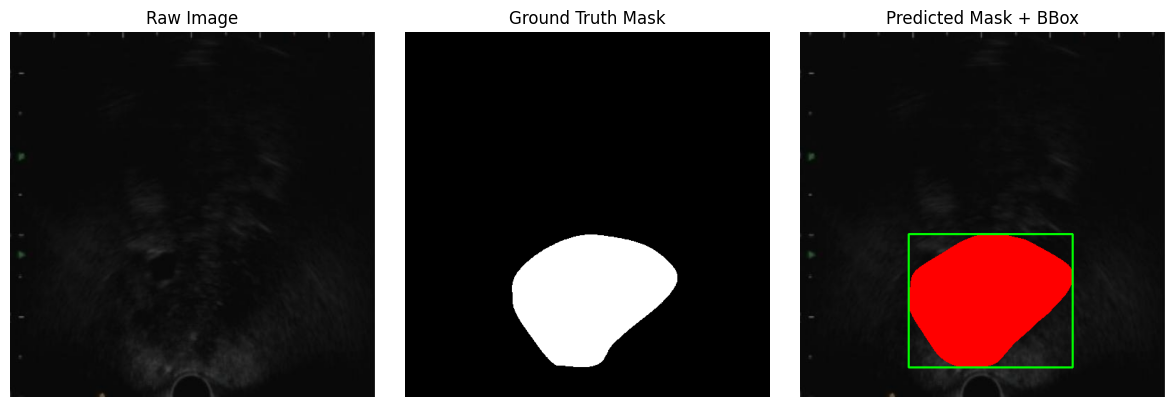

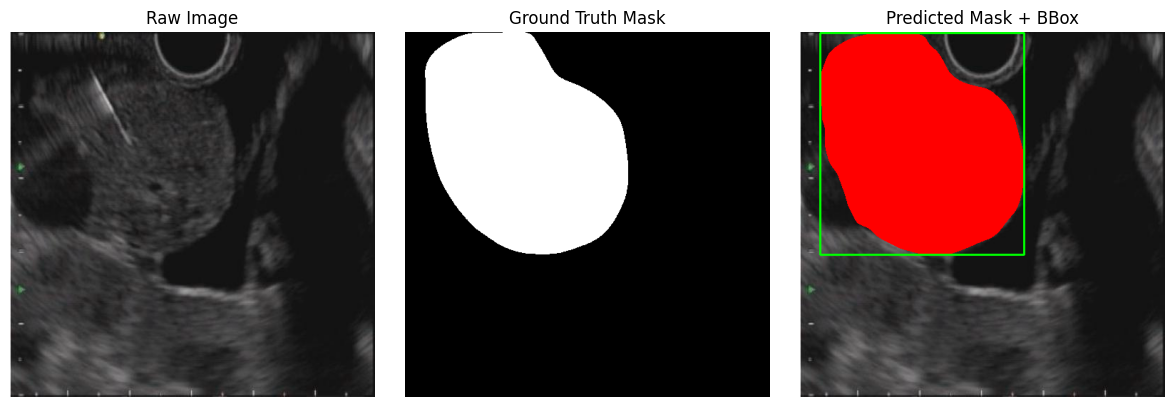

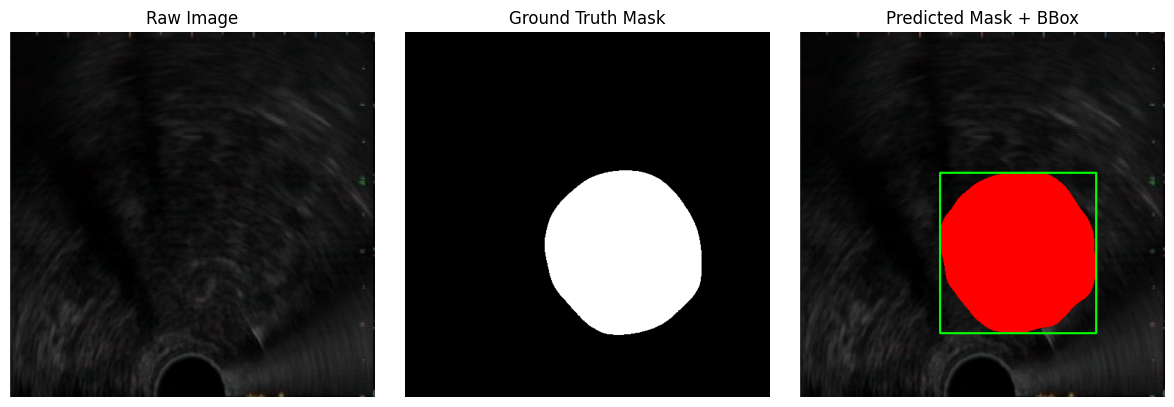

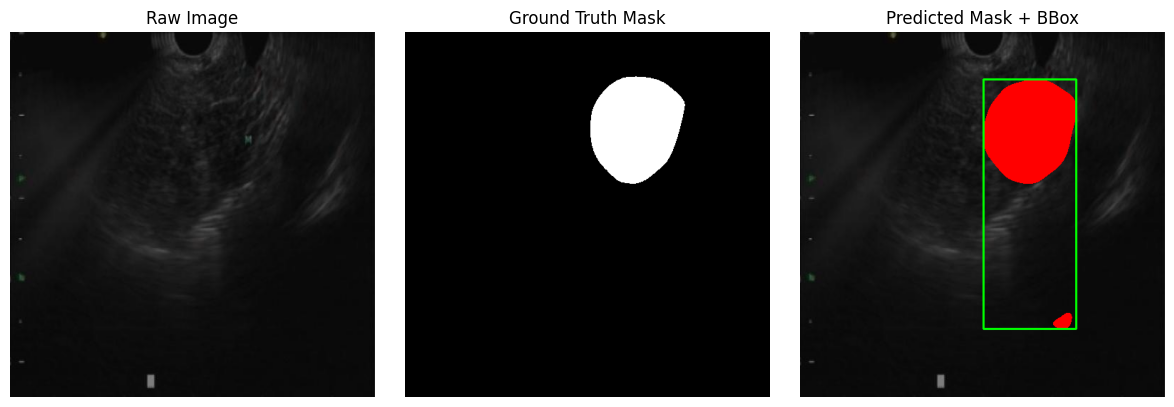

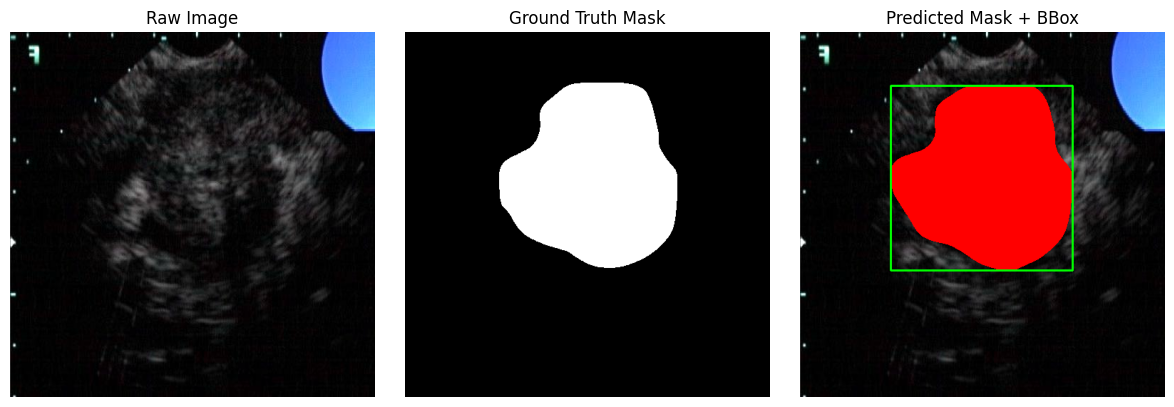

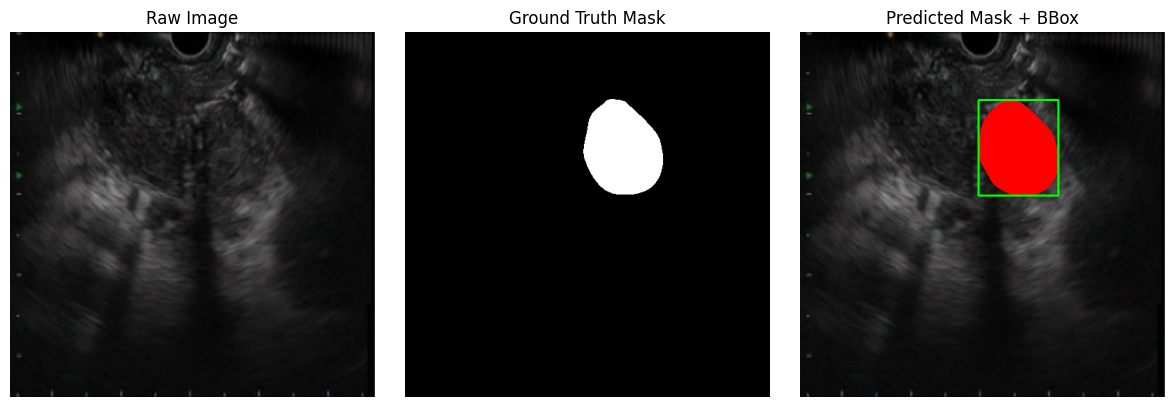

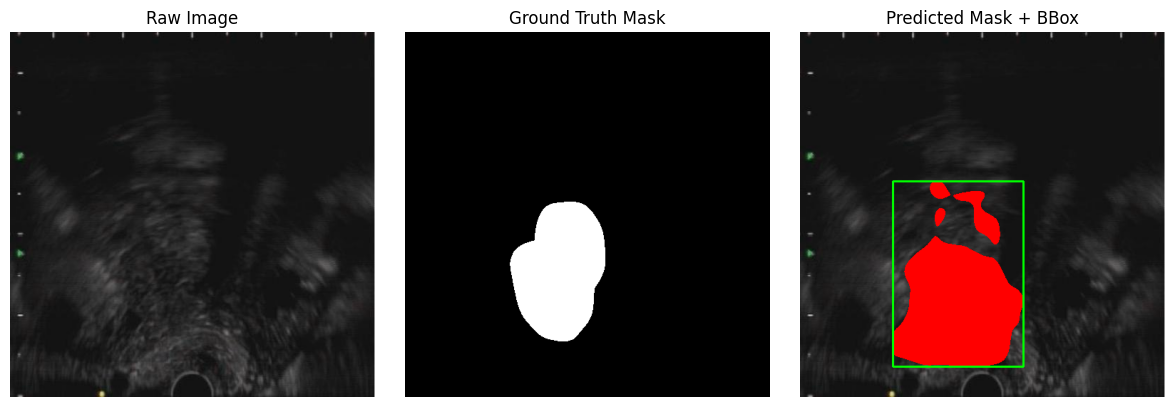

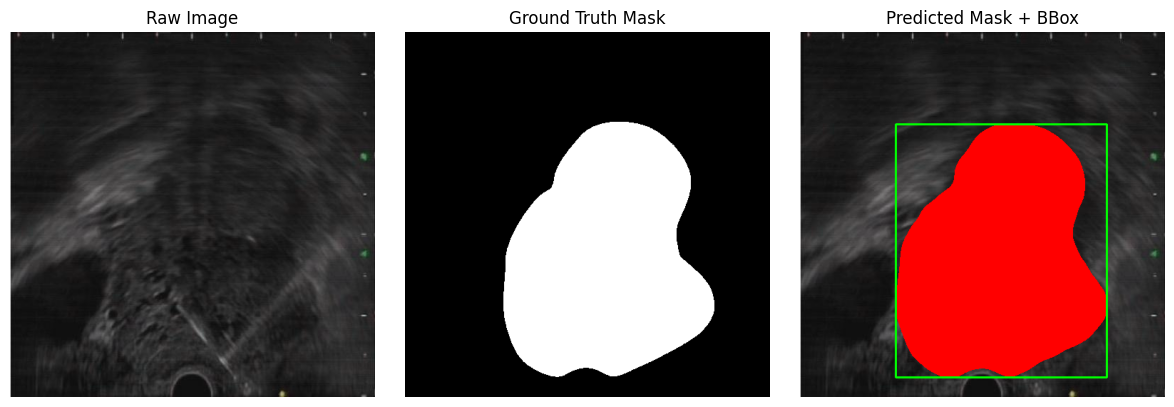

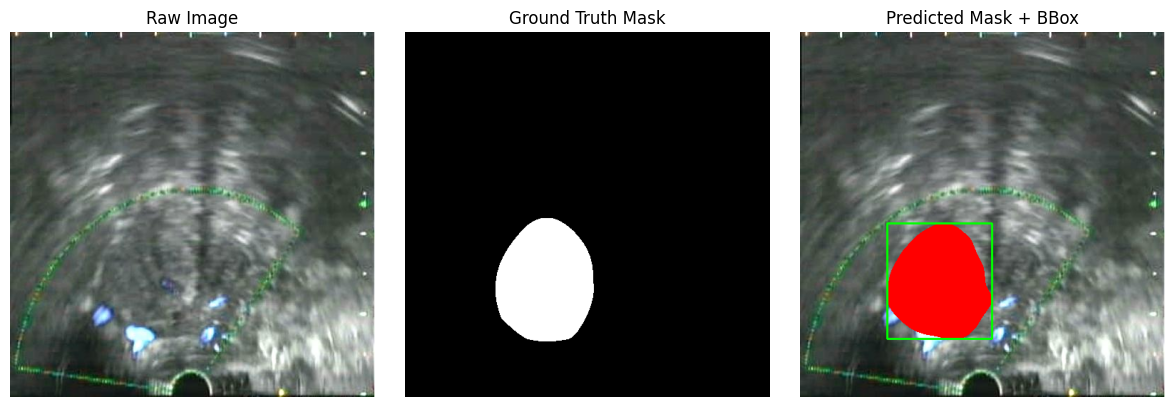

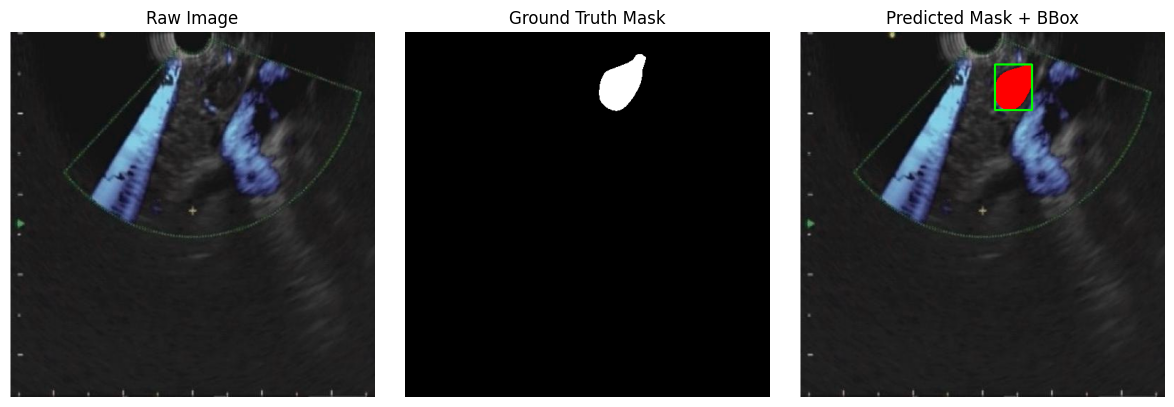

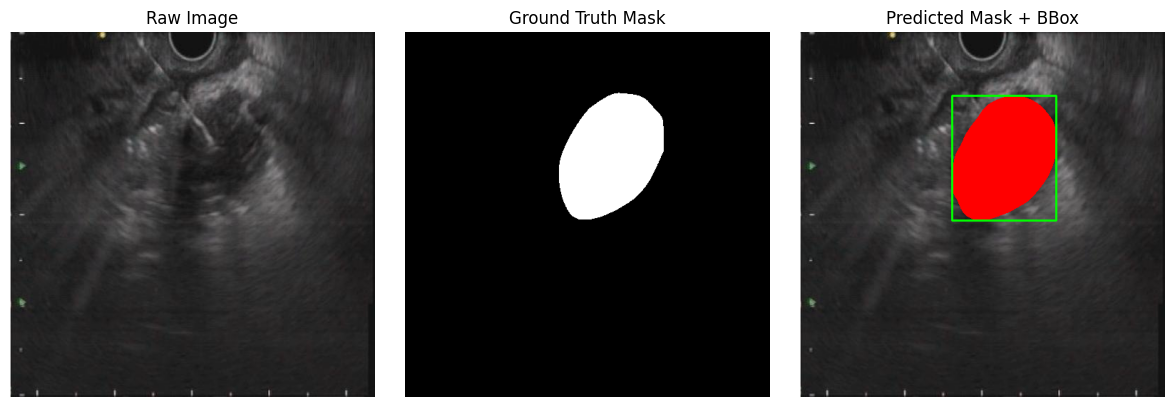

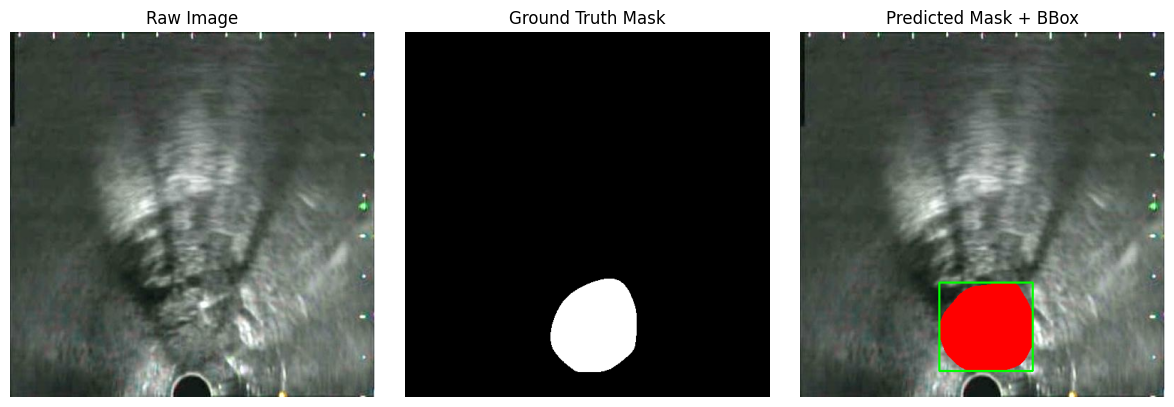

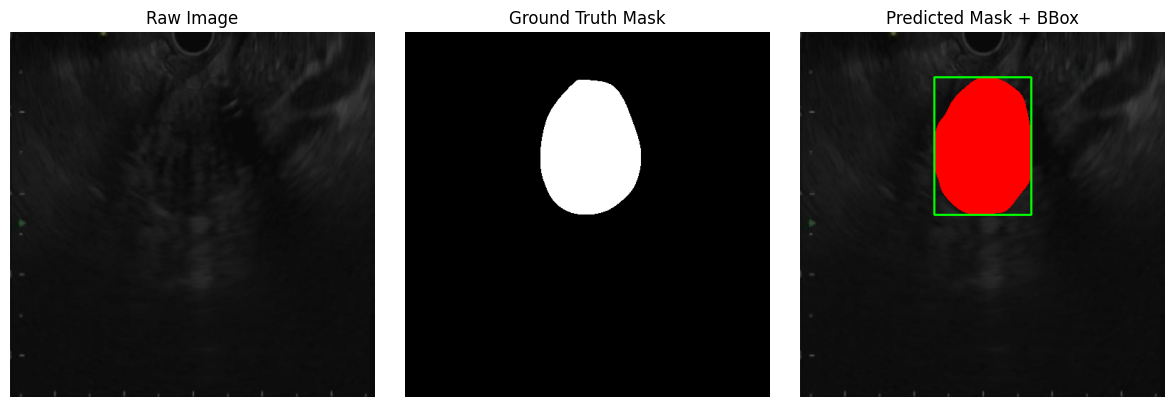

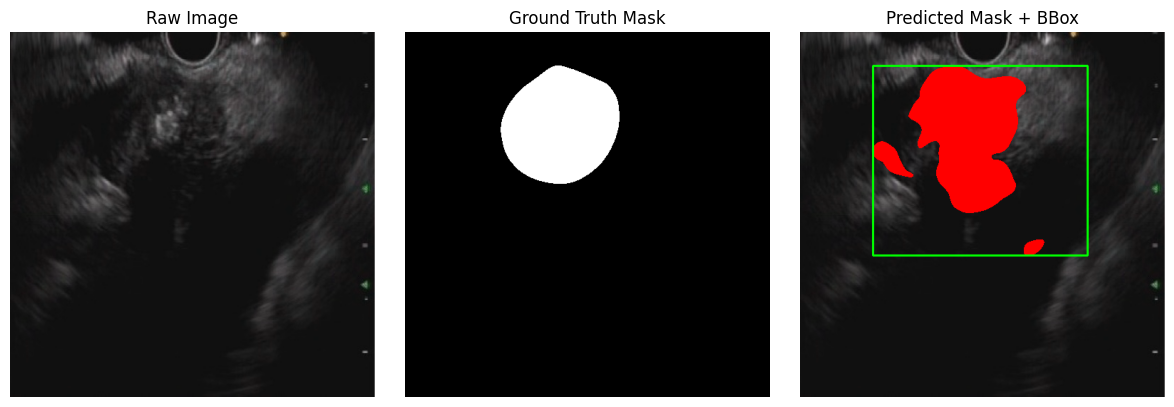

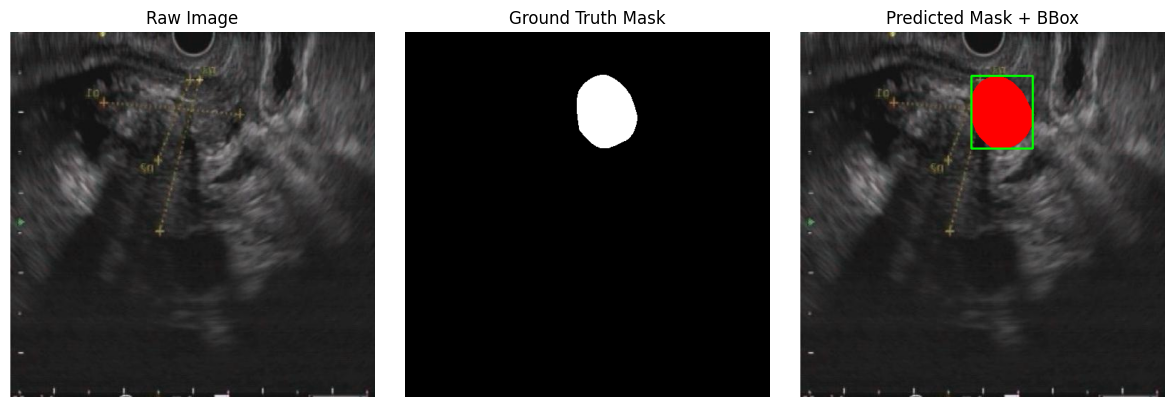

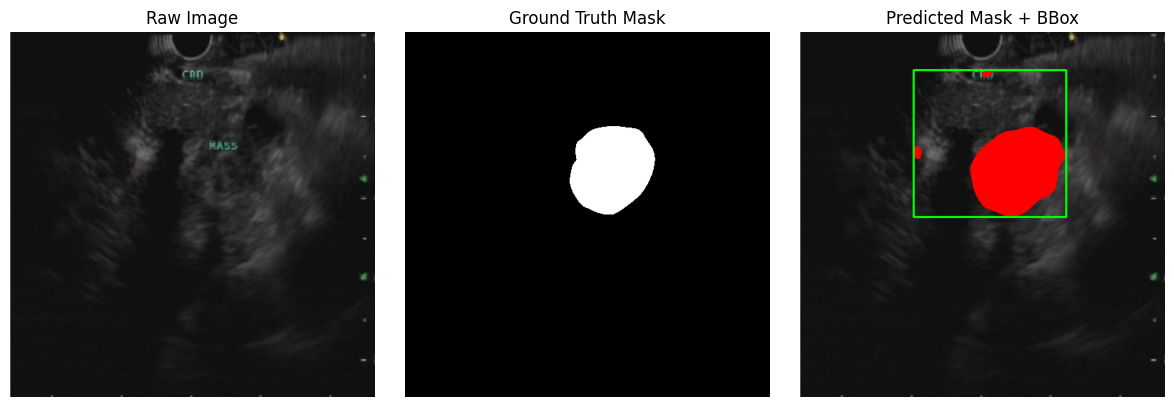

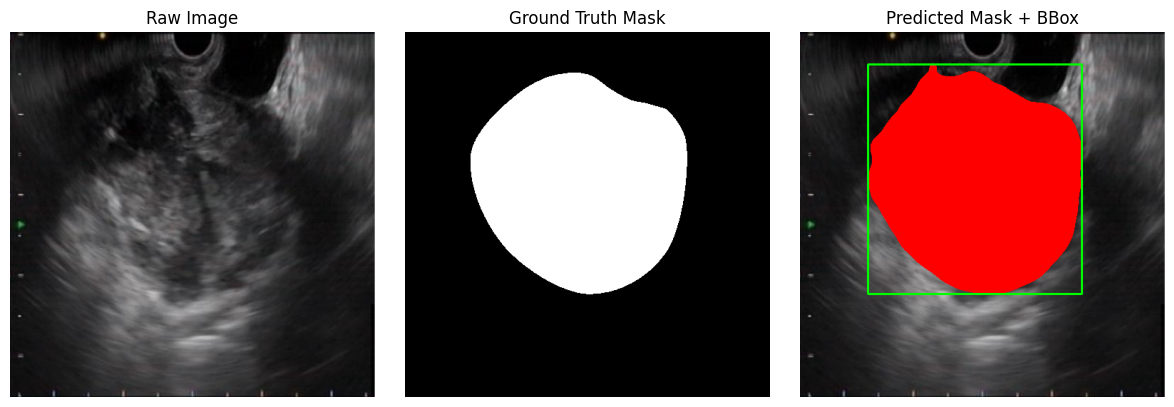

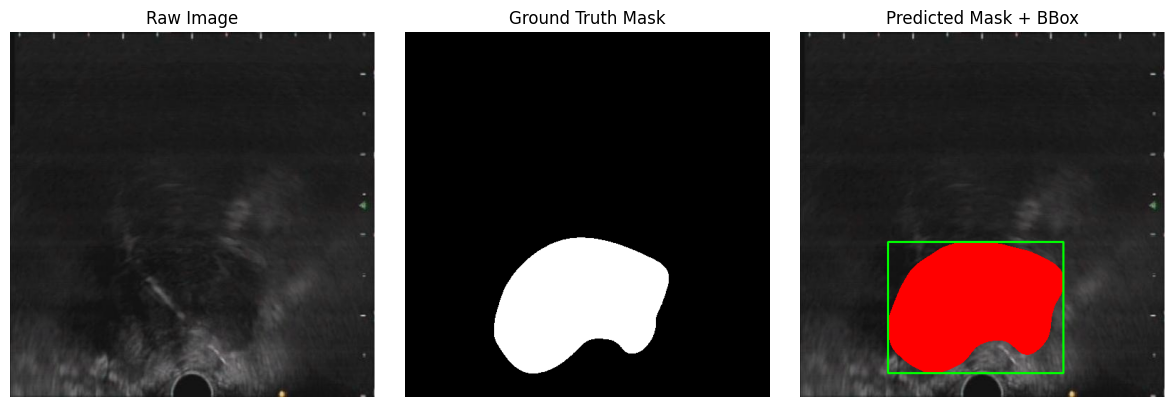

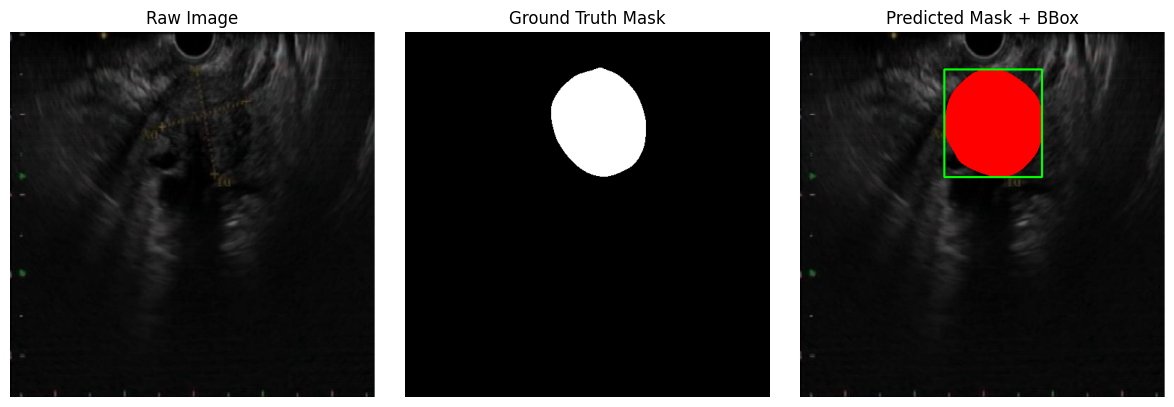

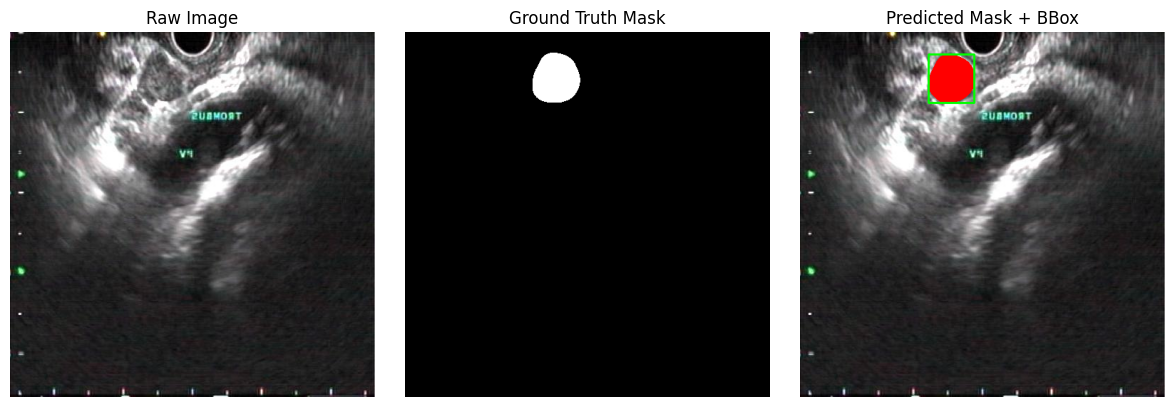

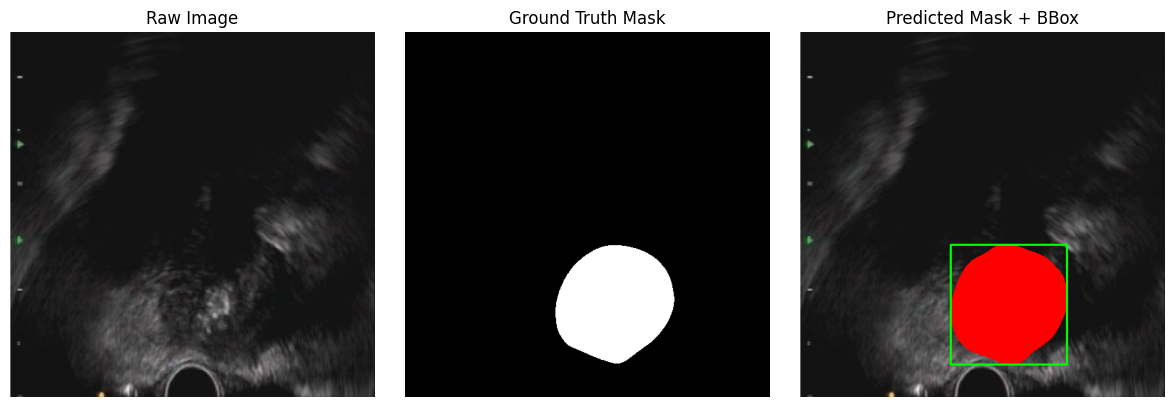

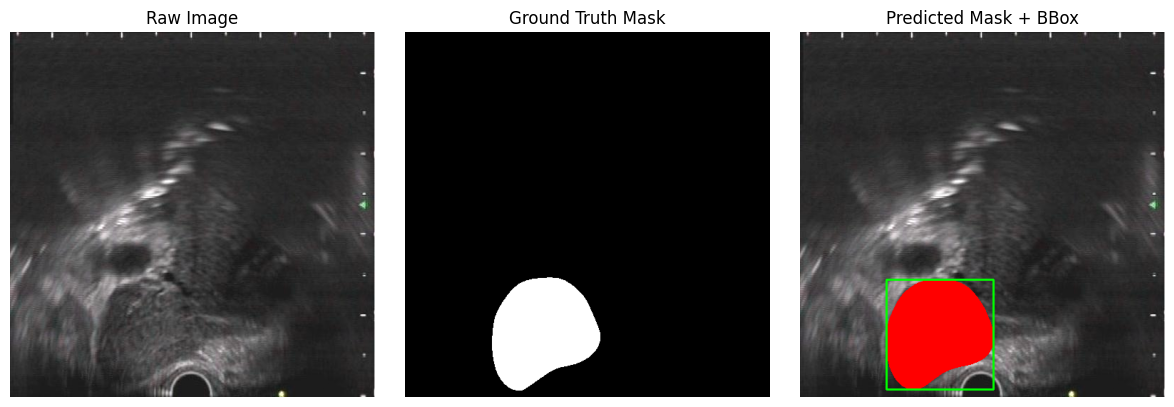

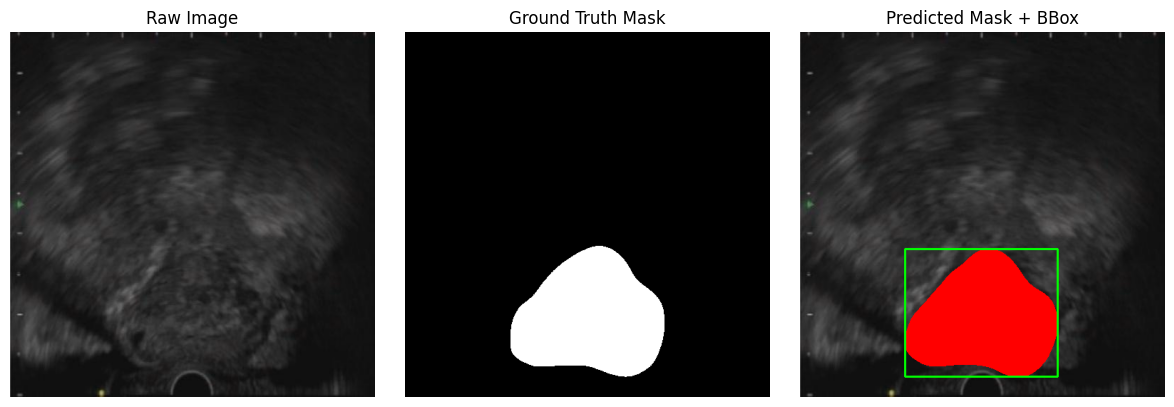

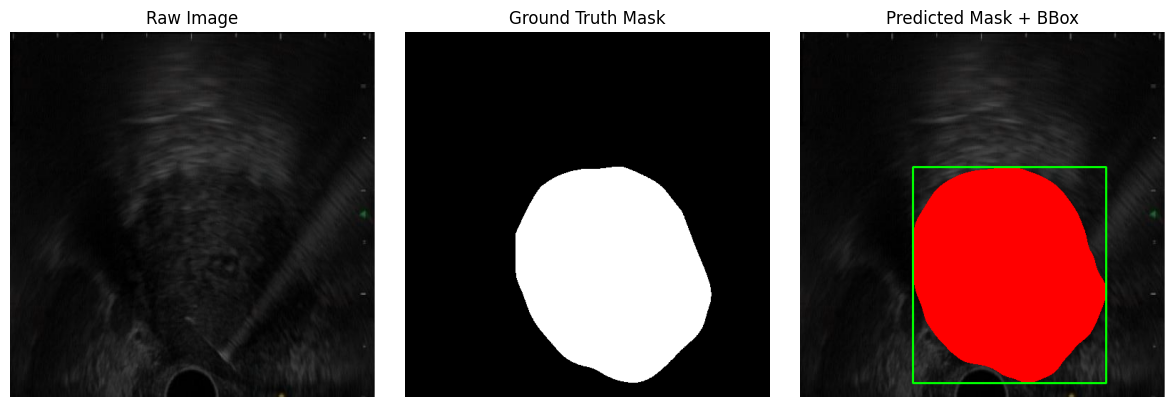

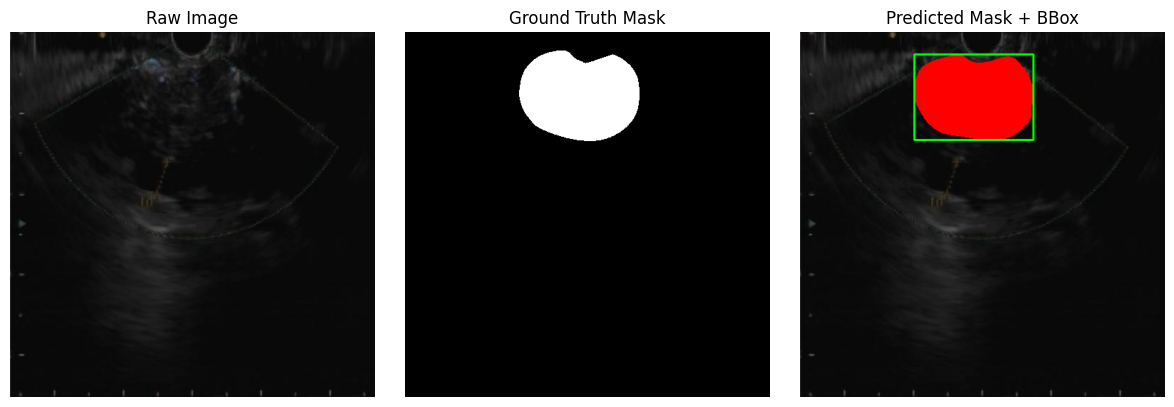

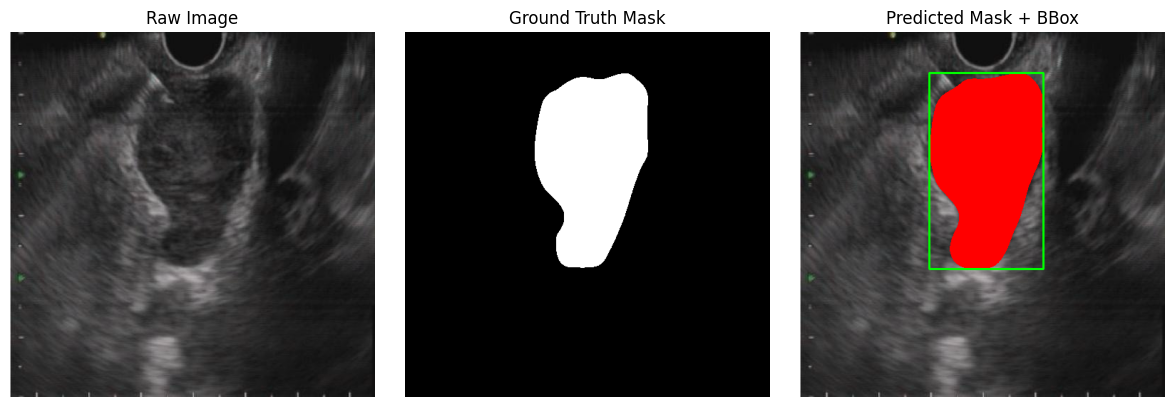

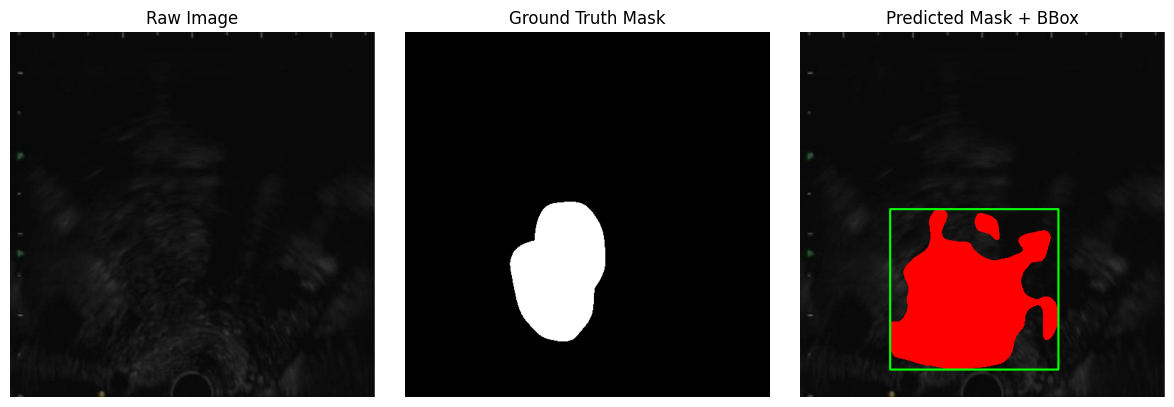

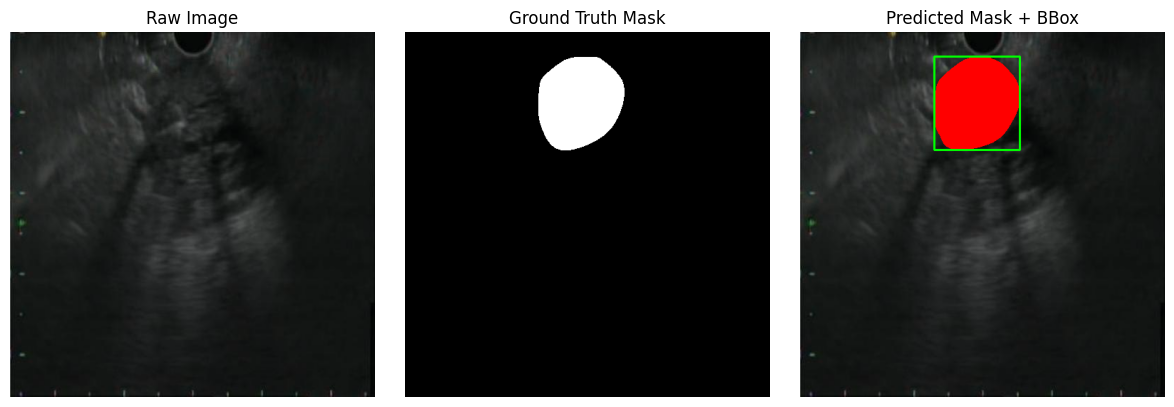

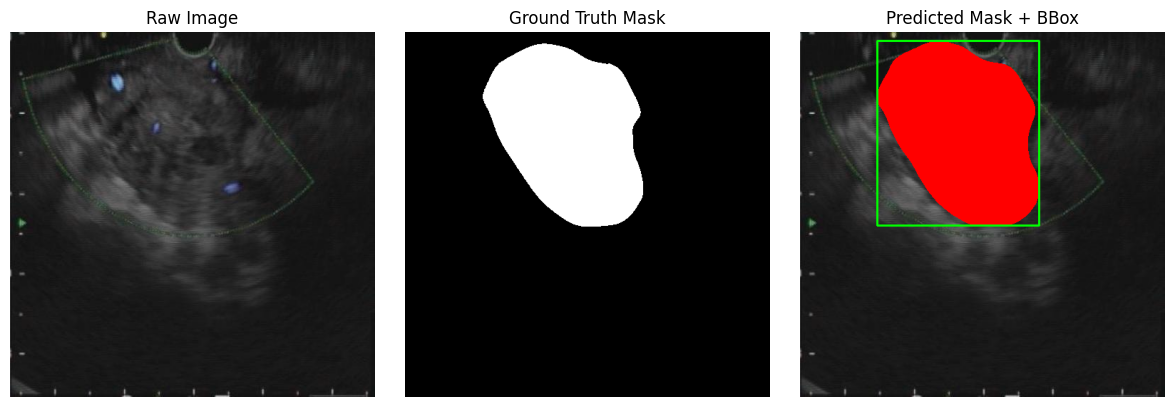

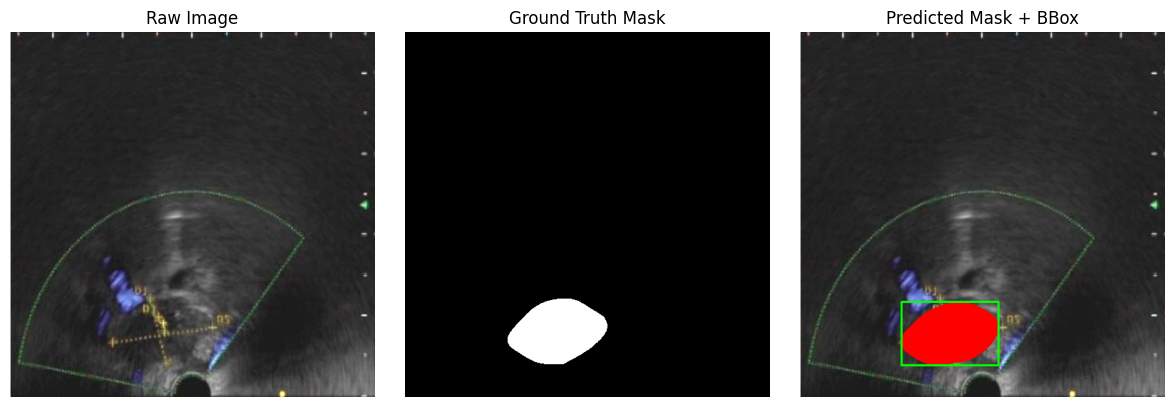

In [12]:
test_gen = TumorSegmentationGenerator(test_images, test_masks, batch_size=4)

visualize_predictions_triplet_colored_with_bbox(model, test_gen, num_images=30)

Melakukan evaluasi terhadap model yang telah dirancang untuk melihat tingkat keberhasilkan model dalam melakukan segmentasi

In [13]:
def evaluate_and_plot(model, test_gen):
    y_trues = []
    y_preds = []

    for i in range(len(test_gen)):
        x, y = test_gen[i]

        y_true = y[0]
        if y_true.ndim == 3:
            y_true = y_true[:, :, 0]

        output = model.predict(x, verbose=0)
        y_pred = output[0]
        if y_pred.ndim == 4:
            y_pred = y_pred[0, :, :, 0]
        elif y_pred.ndim == 3:
            y_pred = y_pred[:, :, 0]

        if y_pred.shape != y_true.shape:
            y_pred = tf.image.resize(y_pred[..., np.newaxis], y_true.shape, method='bilinear').numpy().squeeze()

        y_trues.extend(y_true.flatten())
        y_preds.extend(y_pred.flatten())

    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)
    y_preds_binary = (y_preds > 0.5).astype(np.uint8)

    # Metrics
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve,
        average_precision_score, jaccard_score
    )

    acc = accuracy_score(y_trues, y_preds_binary)
    prec = precision_score(y_trues, y_preds_binary, zero_division=0)
    rec = recall_score(y_trues, y_preds_binary, zero_division=0)
    f1 = f1_score(y_trues, y_preds_binary, zero_division=0)
    dice = 2 * (prec * rec) / (prec + rec + 1e-6)
    iou = jaccard_score(y_trues, y_preds_binary, zero_division=0)

    cm = confusion_matrix(y_trues, y_preds_binary)
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    auc_score = roc_auc_score(y_trues, y_preds)
    precision_vals, recall_vals, _ = precision_recall_curve(y_trues, y_preds)
    avg_prec = average_precision_score(y_trues, y_preds)

    # Plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color="orange", label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(recall_vals, precision_vals, color="green", label=f"AP = {avg_prec:.2f}")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Dice     : {dice:.4f}")
    print(f"IoU      : {iou:.4f}")

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


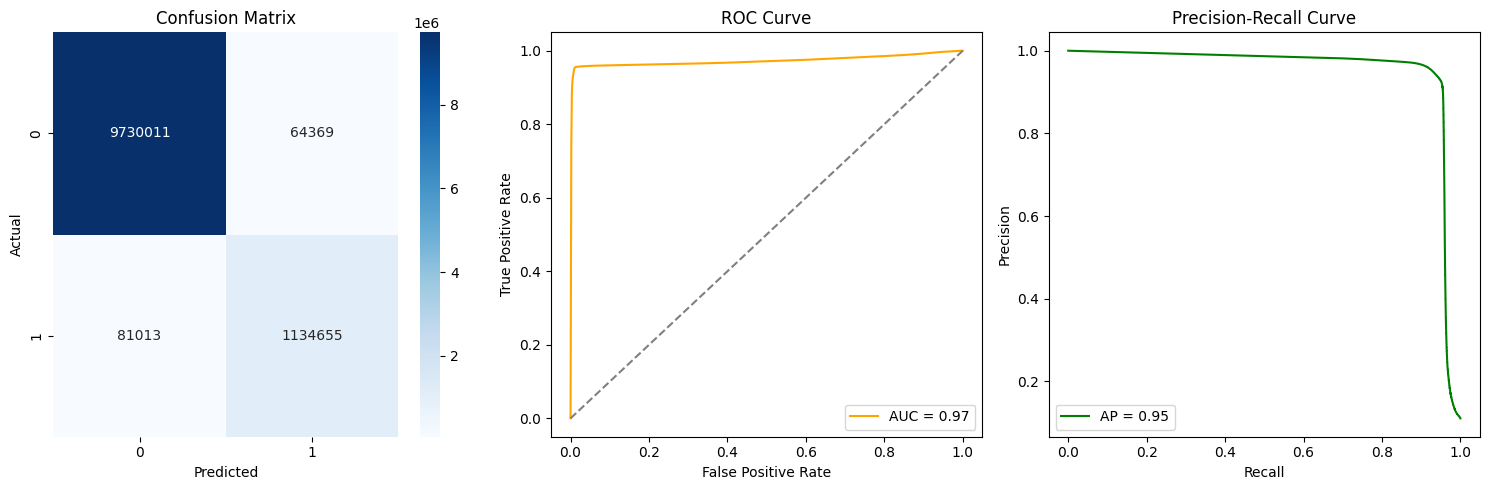

Accuracy : 0.9868
Precision: 0.9463
Recall   : 0.9334
F1 Score : 0.9398
Dice     : 0.9398
IoU      : 0.8864


In [14]:
evaluate_and_plot(model, test_gen)

Dapat terlihat bahwa model menghasilkan tingkat accuracy sebesar 98,3%, tingkat precision sebesar 93,6%, nilai recall sebesar 88%, nilai F1 score sebesar 90%, dengan dice coef sebesar 0.907, dan nilai IoU sebesar 0.831.

Dari nilai-nilai tersebut dapat disimpulkan bahwa model yang telah dirancang dapat melakukan segmentasi tumor pankreas dengan tepat dan menghasilkan prediksi yang cukup baik